# BMW Sales Classification Project (2010-2024)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    precision_score, recall_score, confusion_matrix, classification_report
)


## Data Loading and Overviewing

In [2]:
df_bmw_sales = pd.read_csv(r"C:\Users\safon\Desktop\BMW sales data (2010-2024) (1).csv")

In [3]:
df_bmw_sales.head(10)

,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low
5,5 Series,2017,Middle East,Silver,Diesel,Manual,1.9,171362,42926,1232,Low
6,i8,2022,Europe,White,Diesel,Manual,1.8,196741,55064,7949,High
7,M5,2014,Asia,Black,Diesel,Automatic,1.6,121156,102778,632,Low
8,X3,2016,South America,White,Diesel,Automatic,1.7,48073,116482,8944,High
9,i8,2019,Europe,White,Electric,Manual,3.0,35700,96257,4411,Low


In [4]:
df_bmw_sales.shape

(50000, 11)

In [5]:
df_bmw_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


In [6]:
df_bmw_sales.describe()

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


In [7]:
df_bmw_sales.nunique()

Model                      11
Year                       15
Region                      6
Color                       6
Fuel_Type                   4
Transmission                2
Engine_Size_L              36
Mileage_KM              44347
Price_USD               38246
Sales_Volume             9845
Sales_Classification        2
dtype: int64

In [8]:
df_bmw_sales.isna().sum()

Model                   0
Year                    0
Region                  0
Color                   0
Fuel_Type               0
Transmission            0
Engine_Size_L           0
Mileage_KM              0
Price_USD               0
Sales_Volume            0
Sales_Classification    0
dtype: int64

In [9]:
df_bmw_sales.duplicated().sum()

0

## EDA (Exploratory Data Analysis)

In [10]:
target = 'Sales_Classification' 
numeric_cols = df_bmw_sales.select_dtypes(exclude='object').columns 
cat_cols = [col for col in bmw_sales_df.select_dtypes(include='object').columns if col != target]

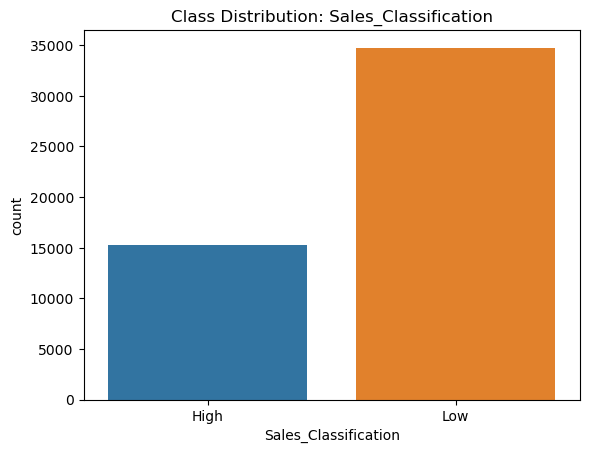

In [11]:
sns.countplot(x=target, data=df_bmw_sales)
plt.title(f'Class Distribution: {target}')
plt.show()

**Observation:** 

The target is imbalanced, so we will use `class_weight='balanced'` in Random Forest  to ensure the model correctly accounts for both classes.



In [12]:
for col in cat_cols:
    print(f"{col}:\n{df_bmw_sales[col].value_counts(normalize=True)}\n")

Model:
Model
7 Series    0.09332
i3          0.09236
i8          0.09212
3 Series    0.09190
5 Series    0.09184
X1          0.09140
X3          0.08994
X5          0.08974
M5          0.08956
X6          0.08956
M3          0.08826
Name: proportion, dtype: float64

Region:
Region
Asia             0.16908
Middle East      0.16746
North America    0.16670
Europe           0.16668
Africa           0.16506
South America    0.16502
Name: proportion, dtype: float64

Color:
Color
Red       0.16926
Silver    0.16700
Grey      0.16696
White     0.16608
Black     0.16546
Blue      0.16524
Name: proportion, dtype: float64

Fuel_Type:
Fuel_Type
Hybrid      0.25432
Petrol      0.25100
Electric    0.24942
Diesel      0.24526
Name: proportion, dtype: float64

Transmission:
Transmission
Manual       0.50308
Automatic    0.49692
Name: proportion, dtype: float64



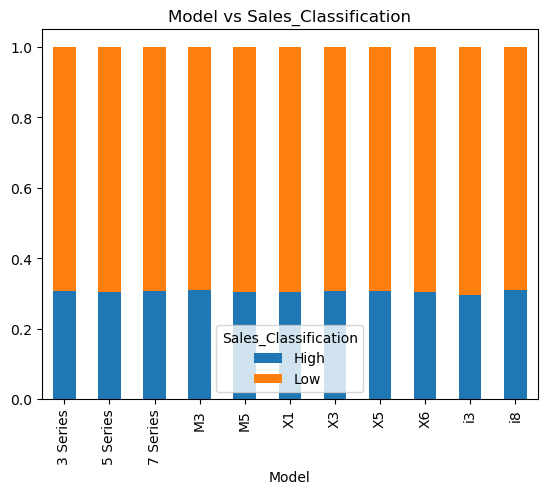

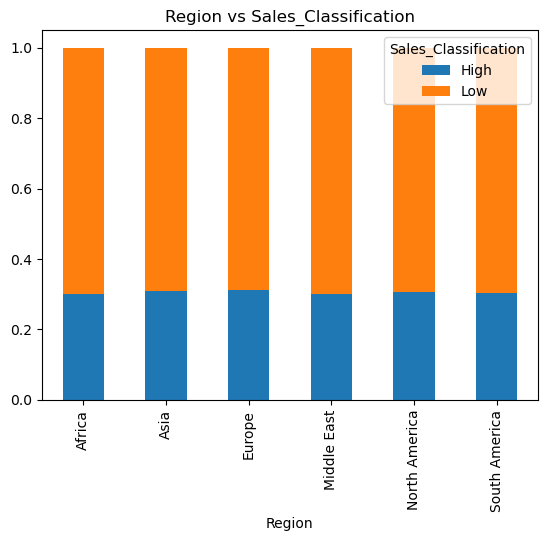

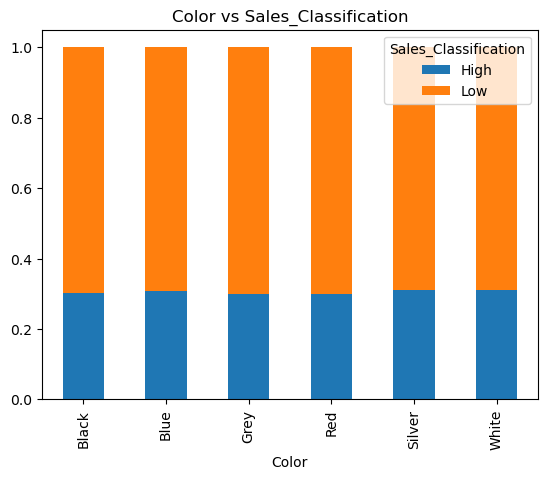

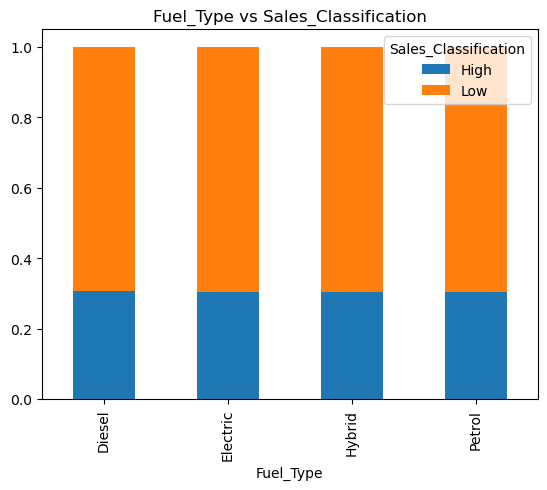

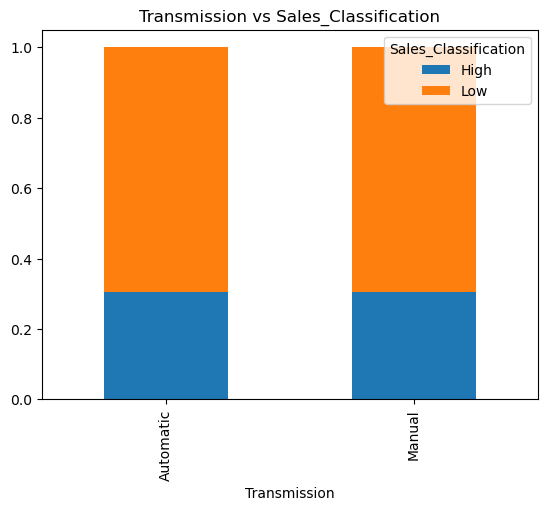

In [13]:
for col in cat_cols:
    cross = pd.crosstab(df_bmw_sales[col], df_bmw_sales['Sales_Classification'], normalize='index')
    cross.plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Sales_Classification')
    plt.show()

In [14]:
for col in cat_cols:
    contingency = pd.crosstab(df_bmw_sales[col], df_bmw_sales[target])
    chi2, p, dof, ex = chi2_contingency(contingency)
    print(f"{col}: p-value = {p}")

Model: p-value = 0.9714499333134624
Region: p-value = 0.281243202071958
Color: p-value = 0.22805849130478523
Fuel_Type: p-value = 0.9748465259933686
Transmission: p-value = 0.7198883487108411


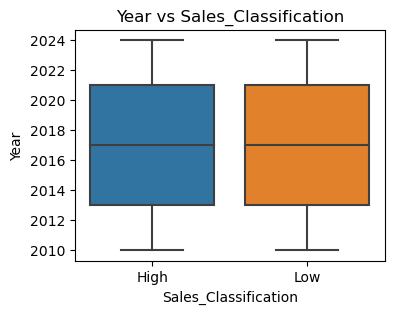

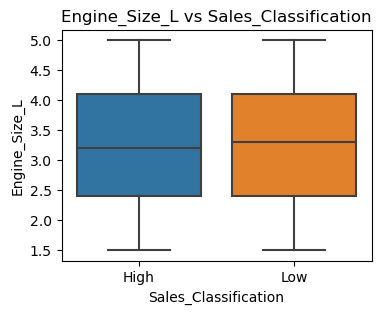

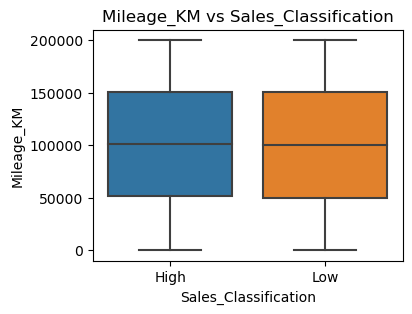

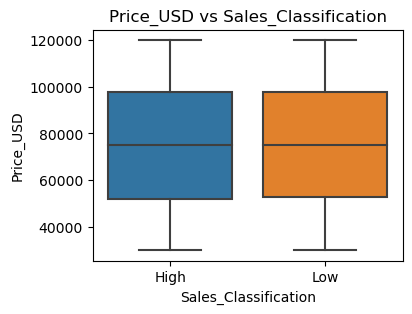

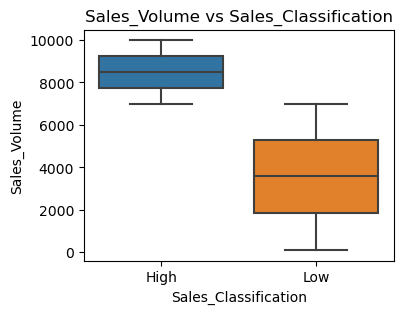

In [15]:
for col in numeric_cols:
    plt.figure(figsize=(4,3))
    sns.boxplot(x=target, y=col, data=df_bmw_sales)
    plt.title(f'{col} vs {target}')
    plt.show()


In [16]:
df_bmw_sales.groupby('Sales_Classification')['Sales_Volume'].agg(['min', 'max'])

,min,max
Sales_Classification,,
High,7000,9999
Low,100,6999


**Observation:**
    
Sales_Volume almost completely separates Low and High classes.  
The extreme values (whiskers) exactly match.  
This is a strong signal that the feature is highly correlated with the target.  
For now, we will keep it in the dataset and decide about removing it after evaluating the model, to confirm whether it represents data leakage.



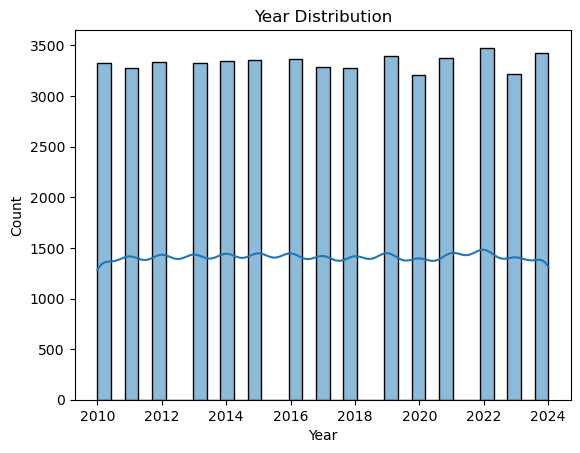

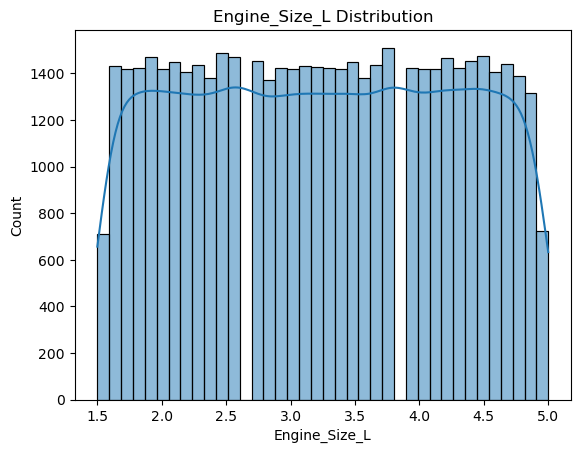

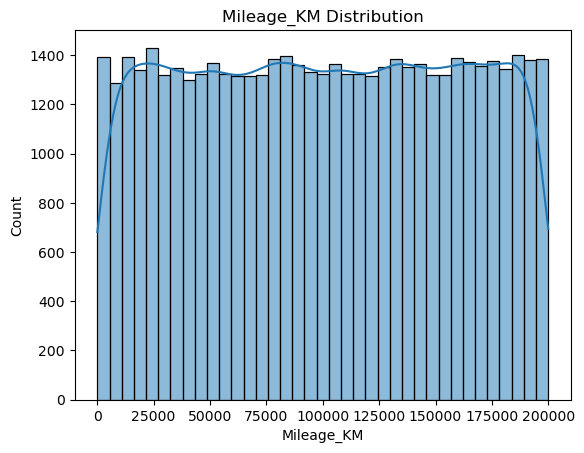

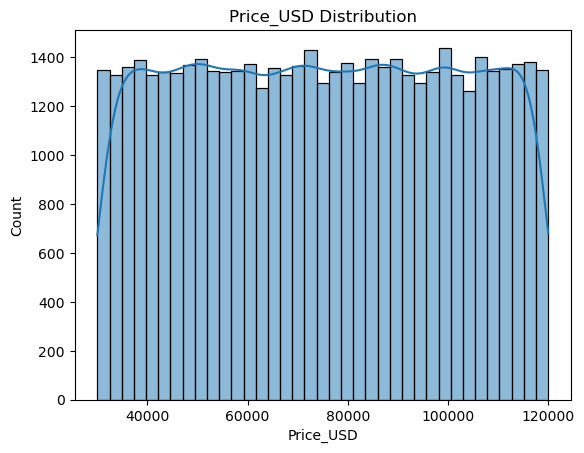

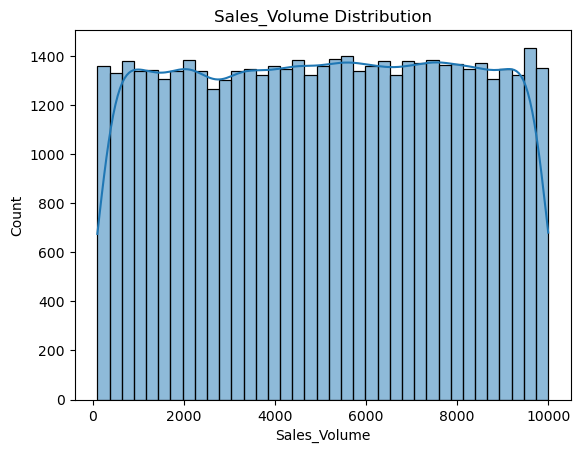

In [17]:
for col in numeric_cols:
    sns.histplot(df_bmw_sales[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.show()

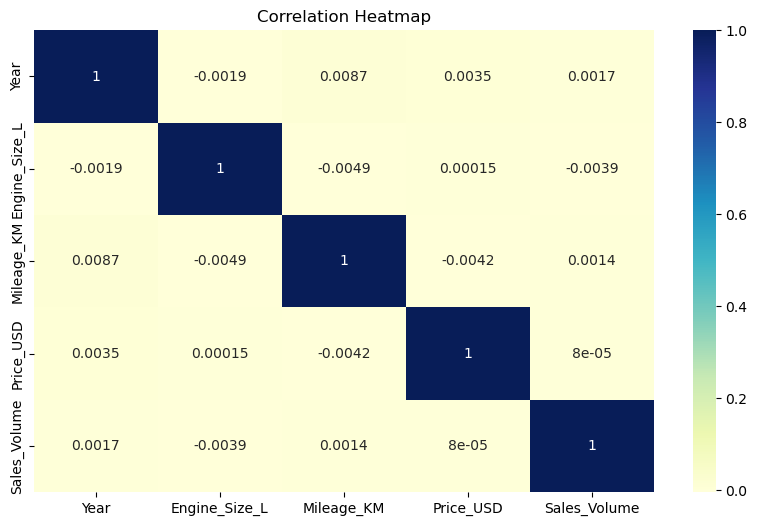

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(df_bmw_sales[numeric_cols].corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show() 

In [19]:
for col in numeric_cols:
    z_scores = zscore(df_bmw_sales[col].dropna())
    outliers = sum(abs(z_scores) > 3)
    print(f'{col}: {outliers} potential outliers')


Year: 0 potential outliers
Engine_Size_L: 0 potential outliers
Mileage_KM: 0 potential outliers
Price_USD: 0 potential outliers
Sales_Volume: 0 potential outliers


## Data Cleaning & Preprocessing

In [20]:
X = df_bmw_sales.drop(columns=['Sales_Classification'])
y = df_bmw_sales['Sales_Classification'].map({'Low': 0, 'High': 1})

In [21]:
# `Year` transformed into `Years_Since_First_Sale` to represent a time trend
df_bmw_sales['Years_Since_First_Sale'] = df_bmw_sales['Year'] - df_bmw_sales['Year'].min()

In [22]:
numeric_features = ['Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume','Years_Since_First_Sale']
categorical_features = ['Model', 'Region', 'Color', 'Fuel_Type', 'Transmission']

In [23]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

## Modeling

In [26]:
# Baseline Model
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [27]:
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Year', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Model', 'Region', 'Color',
                                                   'Fuel_Type',
                                                   'Transmission'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [28]:
y_pred_baseline = baseline_pipeline.predict(X_test)

In [29]:
# GridSearch Model
param_grid = {
        'clf__n_estimators':[100,200],
        'clf__max_depth':[None,10,20],
        'clf__min_samples_split':[2,5],

        'clf__min_samples_leaf':[1,2],
    }

In [30]:
grid_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [31]:
grid_search = GridSearchCV(
    estimator=grid_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',     
    cv=5,               
    n_jobs=-1,         
    verbose=2          
)

In [32]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Year', 'Engine_Size_L', 'Mileage_KM', 'Price_USD', 'Sales_Volume'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Model',
                                                                          'Region',
                                                                          'Color',
                                                                          'Fuel_Type',
                                                                          'Transmission'])])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__min_samples_leaf': [1, 2],
                         'clf__min_samples_split': [2, 5],
                         'clf__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [33]:
y_pred_grid = grid_search.predict(X_test)

## Model Evaluation

In [34]:
param_keys = ['max_depth', 'min_samples_leaf', 'min_samples_split', 'n_estimators']
baseline_params = {
    key: baseline_pipeline.named_steps['clf'].get_params()[key] for key in param_keys
}

In [35]:
print("Best parameters Basic Model:", baseline_params)
print("Best parameters Grid Model:", grid_search.best_params_)

Best parameters Basic Model: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters Grid Model: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [36]:
baseline_metrics = {
    'Model': 'Baseline',
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'ROC AUC': roc_auc_score(y_test, y_pred_baseline),
    'F1': f1_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline)
}

In [37]:
grid_metrics = {
    'Model': 'GridSearch',
    'Accuracy': accuracy_score(y_test, y_pred_grid),
    'ROC AUC': roc_auc_score(y_test, y_pred_grid),
    'F1': f1_score(y_test, y_pred_grid),
    'Precision': precision_score(y_test, y_pred_grid),
    'Recall': recall_score(y_test, y_pred_grid)
}

In [38]:
metrics_df = pd.DataFrame([baseline_metrics, grid_metrics])
metrics_df

,Model,Accuracy,ROC AUC,F1,Precision,Recall
0,Baseline,1.0,1.0,1.0,1.0,1.0
1,GridSearch,1.0,1.0,1.0,1.0,1.0


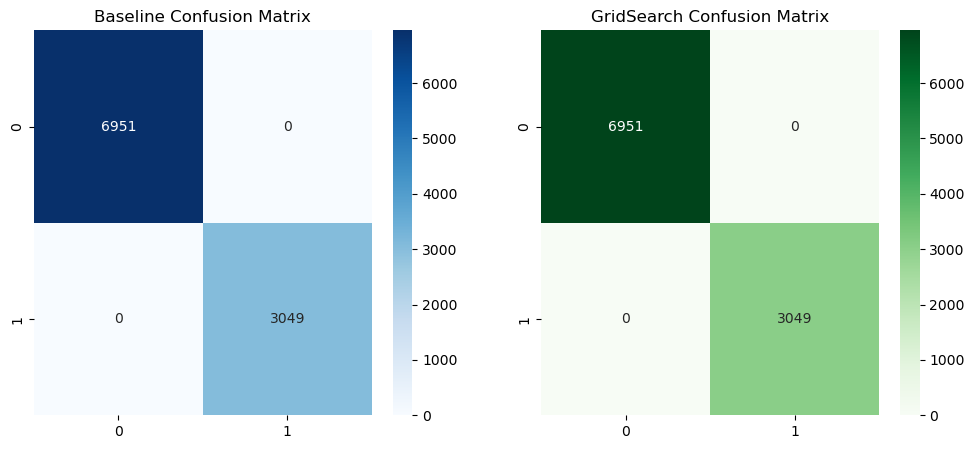

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Baseline Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred_grid), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('GridSearch Confusion Matrix')
plt.show()

**Observation:**

Both baseline and tuned Random Forest models achieved perfect metrics (Accuracy, ROC AUC, F1 = 1.0).  
Such performance is highly unusual and suggests possible **data leakage** or the presence of a dominant feature  
that directly determines the target variable.  

To confirm this, we will review the results of the GridSearchCV parameter combinations  
to check whether all configurations yield the same performance.


In [40]:
print("Total combinations tested:", len(grid_search.cv_results_['params']))
print("ROC AUC for each combination:")
for mean, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(f"{mean:.4f} -> {params}")



Total combinations tested: 24
ROC AUC for each combination:
1.0000 -> {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
1.0000 -> {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
1.0000 -> {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
1.0000 -> {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
1.0000 -> {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
1.0000 -> {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
1.0000 -> {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
1.0000 -> {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 2

## Conclusions / Interpretation

In [41]:
baseline_pipeline = grid_search.best_estimator_

In [42]:
feature_names = baseline_pipeline.named_steps['preprocessor'].get_feature_names_out()

In [43]:
importances = baseline_pipeline.named_steps['clf'].feature_importances_

In [44]:
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

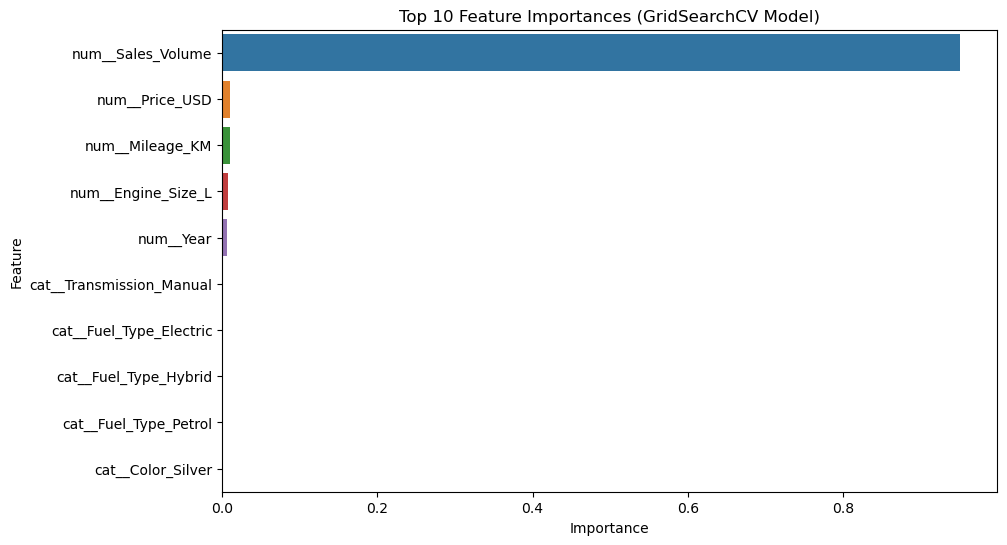

In [45]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(10))
plt.title('Top 10 Feature Importances (GridSearchCV Model)')
plt.show()

**Observation:**

Feature importance analysis shows that `Sales_Volume` overwhelmingly dominates the model,  
accounting for nearly all predictive power. This confirms earlier EDA findings,  
where `Sales_Volume` almost completely separated the target classes.  

Such dominance strongly suggests **data leakage**, as the target variable (`Sales_Classification`)  
was likely derived from this feature.  

**Next step:**  
    
Rebuild the model **without `Sales_Volume`** to verify whether the model can still generalize  
and learn meaningful patterns from the remaining features.



## Model Refinement (Without Sales_Volume)

In [46]:
X_refined = X.drop(columns=['Sales_Volume'])

In [47]:
X_train_ref, X_test_ref, y_train_ref, y_test_ref = train_test_split(
    X_refined, y, test_size=0.2, random_state=42, stratify=y
)

In [48]:
numeric_cols_refined = [col for col in numerical_columns if col != 'Sales_Volume']

In [49]:
preprocessor_refined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols_refined),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [50]:
# Refined Basic Model 
baseline_pipeline_refined = Pipeline([
    ('preprocessor', preprocessor_refined),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [51]:
baseline_pipeline_refined.fit(X_train_ref, y_train_ref)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Engine_Size_L',
                                                   'Mileage_KM', 'Price_USD']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Model', 'Region', 'Color',
                                                   'Fuel_Type',
                                                   'Transmission'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [52]:
y_pred_baseline_ref = baseline_pipeline_refined.predict(X_test_ref)

In [53]:
# Refined Grid Model 
grid_pipeline_refined = Pipeline([
    ('preprocessor', preprocessor_refined),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])


In [54]:
grid_search_refined = GridSearchCV(
    estimator=grid_pipeline_refined,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [55]:
grid_search_refined.fit(X_train_ref, y_train_ref)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Year',
                                                                          'Engine_Size_L',
                                                                          'Mileage_KM',
                                                                          'Price_USD']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Model',
                                                                          'Region',
                                                                          'Color',
                                                                          'Fuel_Type',
                                                                          'Transmission'])])),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__min_samples_leaf': [1, 2],
                         'clf__min_samples_split': [2, 5],
                         'clf__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [56]:

y_pred_grid_ref = grid_search_refined.predict(X_test_ref)

## Model Evaluation (Without Sales_Volume)


In [57]:
baseline_params_ref = {
    key: baseline_pipeline_refined.named_steps['clf'].get_params()[key] for key in param_keys
}

In [58]:
print("Best parameters Refined Basic Model:", baseline_params_ref)
print("Best parameters Refined Grid Model:", grid_search_refined.best_params_)

Best parameters Refined Basic Model: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters Refined Grid Model: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


In [59]:
baseline_metrics_ref = {
    'Model': 'Refined Baseline ',
    'Accuracy': accuracy_score(y_test, y_pred_baseline_ref),
    'ROC AUC': roc_auc_score(y_test, y_pred_baseline_ref),
    'F1': f1_score(y_test, y_pred_baseline_ref),
    'Precision': precision_score(y_test, y_pred_baseline_ref),
    'Recall': recall_score(y_test, y_pred_baseline_ref)
}

In [60]:
grid_metrics_ref = {
    'Model': 'Refined GridSearch',
    'Accuracy': accuracy_score(y_test, y_pred_grid_ref),
    'ROC AUC': roc_auc_score(y_test, y_pred_grid_ref),
    'F1': f1_score(y_test, y_pred_grid_ref),
    'Precision': precision_score(y_test, y_pred_grid_ref),
    'Recall': recall_score(y_test, y_pred_grid_ref)
}

In [61]:
metrics_df_refined = pd.DataFrame([
    baseline_metrics,
    grid_metrics,
    baseline_metrics_ref,
    grid_metrics_ref
])
metrics_df_refined

,Model,Accuracy,ROC AUC,F1,Precision,Recall
0,Baseline,1.0000,1.000000,1.000000,1.000000,1.000000
1,GridSearch,1.0000,1.000000,1.000000,1.000000,1.000000
2,Refined Baseline,0.6904,0.500393,0.025802,0.317829,0.013447
3,Refined GridSearch,0.5759,0.492228,0.285425,0.293486,0.277796


**Observation:**

After removing `Sales_Volume`, the model performance dropped dramatically.
This confirms that `Sales_Volume` was overwhelmingly driving predictions and likely introduced **data leakage**.  
The model without this feature shows that the remaining variables alone are not sufficient for accurate classification,  
highlighting the importance of careful feature selection and validation.


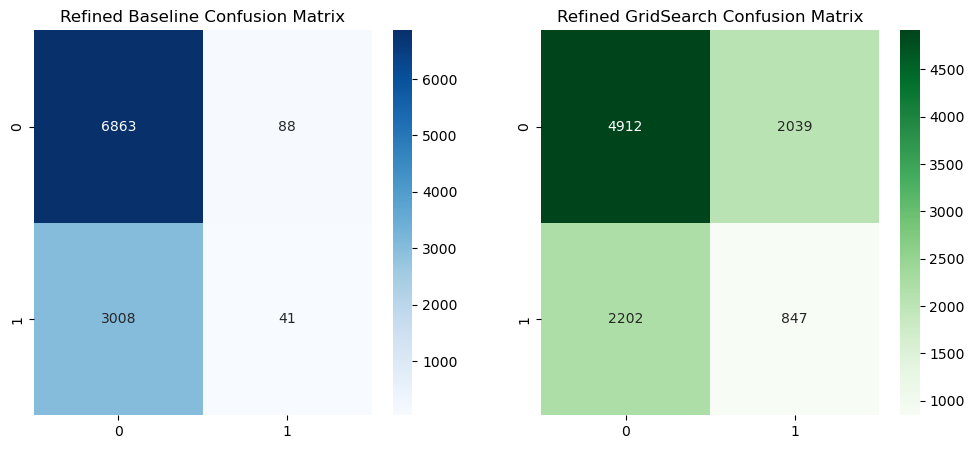

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_baseline_ref), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Refined Baseline Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred_grid_ref), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Refined GridSearch Confusion Matrix')
plt.show()

## Conclusions

1. **Data Overview & EDA**  
   - Target classes were imbalanced.  
   - `Sales_Volume` almost perfectly separates Low and High, suggesting potential data leakage.


2. **Modeling with Sales_Volume**  
   - Baseline and GridSearch models achieved perfect metrics.  
   - Feature importance confirmed that `Sales_Volume` dominated predictions.


3. **Modeling without Sales_Volume**  
   - Performance dropped drastically: Accuracy ~0.57–0.69, ROC AUC ~0.5.  
   - Confusion matrices show poor recognition of the positive class.  
   - Feature importance is more evenly distributed, but remaining features are insufficient for accurate predictions.
    

4. **Key Takeaways**  
   - Importance of careful EDA and checking for data leakage.  
   - Dominant features can mask the weakness of other predictors.  
   - Always validate models by testing feature influence and robustness.
